### Markov Chain to predict the stock market, based on the post from Pranab Gosh "Customer Conersion Prediction with Markov Chain Classifier" (https://pkghosh.wordpress.com/2015/07/06/customer-conversion-prediction-with-markov-chain-classifier/) 
### -->  binary classification with two transition matrices (first ordered matrix), positive and negative

### 1) First-Order Transition Matrix

In [2]:
!pwd

/Users/mikiya/wormhole/Data/DataSci/ML/markov_chain


In [3]:
!ls pic

first-order-matrix.png


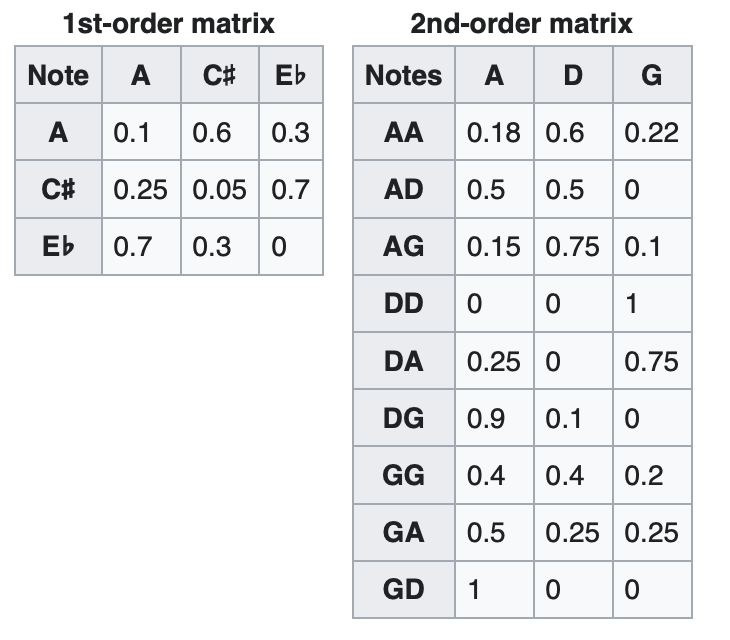

In [4]:
# insert image using python package
from IPython.display import Image
Image(filename="./pic/first-order-matrix.png", width=400)

### 2) Gataloging Patterns Using Market Data
#### &#x23f5; 10 years of S&P 500 index data represents only one sequence of many events leading to the last quoted price. Breaking data into may samples of sequences leading to different price patterns for model to learn richer and diverse patterns, I use the moving average to understand this

### 3) example
#### &#x23f5; 2012-10-18 to 2012-11-21 
1417.26 -> 1428.39 -> 1394.53 -> 1377.51 -> Next Day Volume Up
#### &#x23f5; 2016-08-12 to 2016-08-22
2184.05 -> 2190.15 -> 2178.15 -> 2182.22 -> 2187.02 -> Next Day Volume Up 
#### &#x23f5; 2014-04-04 to 2014-04-10
1865.09 -> 1854.04 -> Next Day Volume Down

### 4) if any similar price up and down has found compared to historical data in the current dataset, I consider that's a pattern
### 5) Binning Values into n(3) Buckets
In Pranab Ghosh's approach is to simplify each even within a sequence into a single feature. He split the value into 3 groups - Low, Medium, High. The precent difference between one day's price and the previous day's. Once we have collected all of them, binning them into three groups of equal frequency(number of appearance?) using InfoTheo package.
### 6) example
#### &#x23f5; closes, opens, highs, lows, we'll end up with a feature containing four letters: "MLHL" for example
#### &#x23f5; String all the feature events for the sequence and end up with something like this along with the observed outcome: "HMLL" -> "MHHL" -> "LLLH" -> "HMMM" -> Volume Up
### 7) Creating Two Markov Chains, One for Days with Volume Jumps, and another for Volume Drops

-----

-----

# Import Libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import io, base64, os, json, re
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import datetime
from random import randint

## 1) Loading Data

In [3]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from datetime import datetime

In [4]:
start_date = "2012-12-01"
end_date = "2022-12-01"
symbol = "TSLA"

tsla_stock = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
tsla_stock = tsla_stock[["Open", "High", "Low", "Adj Close", "Volume"]]

In [ ]:
# data extraction from date: 2012-12-01 to 2022-12-01, 10 years in total
start_date = "2012-12-01"
end_date = "2022-12-01"

# choosing Tesla for prediction, ticker symbol: TSLA
symbol = "TSLA"
tsla_stock = DataReader(name=symbol, data_source="yahoo", start=start_date, end=end_date)
tsla_stock = tsla_stock[["Open", "High", "Low", "Adj Close", "Volume"]]

In [6]:
tsla_stock.head()

,Open,High,Low,Adj Close,Volume
Date,,,,,
2012-12-03,2.259333,2.333333,2.233333,2.308000,31285500
2012-12-04,2.272000,2.320000,2.236667,2.260000,18949500
2012-12-05,2.254667,2.279333,2.238667,2.247333,9922500
2012-12-06,2.254667,2.320000,2.233333,2.260000,9906000
2012-12-07,2.286667,2.299333,2.256667,2.278000,9966000


In [7]:
tsla_stock.shape

(2517, 5)

## 2) calculating return and range 
1) **Return**: is the change in price of an asset over time, a positive return represents a profit while a negative return marks a loss. Here I used the close price from previous date minus today's price <br>
2) **Range**: the difference between the highest and lowest prices traded for a defined period (day, month or year). Here I used high minus low within a day

In [5]:
# add return and range 
df = tsla_stock.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1 # because latter - previous will cause the last row has no one to divide with, so exclude that row
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2012-12-04,2.272000,2.320000,2.236667,2.260000,18949500.0,-0.020797,0.037258
2012-12-05,2.254667,2.279333,2.238667,2.247333,9922500.0,-0.005605,0.018165
2012-12-06,2.254667,2.320000,2.233333,2.260000,9906000.0,0.005636,0.038806
2012-12-07,2.286667,2.299333,2.256667,2.278000,9966000.0,0.007965,0.018907
2012-12-10,2.295333,2.320000,2.278667,2.304667,13947000.0,0.011706,0.018139


## 3) Turn Date from index to attributes

In [6]:
# show all the columns, since Date is not listed as a column, so it should have been recongized as index
df.columns

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Returns', 'Range'], dtype='object')

In [7]:
df.index

DatetimeIndex(['2012-12-04', '2012-12-05', '2012-12-06', '2012-12-07',
               '2012-12-10', '2012-12-11', '2012-12-12', '2012-12-13',
               '2012-12-14', '2012-12-17',
               ...
               '2022-11-17', '2022-11-18', '2022-11-21', '2022-11-22',
               '2022-11-23', '2022-11-25', '2022-11-28', '2022-11-29',
               '2022-11-30', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=2517, freq=None)

In [8]:
# reset index 
df.reset_index(inplace=True)

In [9]:
# convert Date columns into datetime type 
df["Date"]  = pd.to_datetime(df["Date"])

In [10]:
df.head()

,Date,Open,High,Low,Adj Close,Volume,Returns,Range
0,2012-12-04,2.272000,2.320000,2.236667,2.260000,18949500.0,-0.020797,0.037258
1,2012-12-05,2.254667,2.279333,2.238667,2.247333,9922500.0,-0.005605,0.018165
2,2012-12-06,2.254667,2.320000,2.233333,2.260000,9906000.0,0.005636,0.038806
3,2012-12-07,2.286667,2.299333,2.256667,2.278000,9966000.0,0.007965,0.018907
4,2012-12-10,2.295333,2.320000,2.278667,2.304667,13947000.0,0.011706,0.018139


## 4) Randomize
**step 1. select a certain number of rows, calculating the percentage change between previous day and current day, form a new sub dataset with these new attributes** <br>
**step 2. using pandas built-in method -> pct_change(): (current_date - previous_date) / previous_date** <br>
**step 3. repeat this process for 100,000 times, and therefore will collect 100,000 sub dataset** <br>
**step 4. concatenate those 100,000 dataset as new huge dataset** <br> 

In [11]:
# randomize sequential rows from stock price (that will possibly cause certain pattern), collecting them into a list first
random_set = []

# for loop randomize
for i in range(0, 100000):
    
    nums_of_rows = randint(10, 40) # randomly select a certain number from 10 to 40 as the quantities of a sub dataset
    row_to_begin = randint(0, len(df) - nums_of_rows) # randomly select a row to begin with as forming the sub dataset
    sub_dataset = df.iloc[row_to_begin : row_to_begin + nums_of_rows]
    
    # select the last date in each subset as an indicator for predicting 
    Close_Date = max(sub_dataset["Date"])
    
    # forming the new dataset with new attributes 
    Close_Change = sub_dataset["Adj Close"].pct_change()
    High_Change = sub_dataset["High"].pct_change() 
    Low_Change = sub_dataset["Low"].pct_change() 
    Volume_Change = sub_dataset["Volume"].pct_change() 
    Return_Change = sub_dataset["Returns"].pct_change()
    
    Daily_Change = (sub_dataset["Adj Close"] - sub_dataset["Open"]) / sub_dataset["Open"]
    Volume_Next_Day_Tendency = (sub_dataset["Volume"].shift(-1) - sub_dataset["Volume"]) # use volume as prediction 
    Return_Next_Day_Tendency = (sub_dataset["Returns"].shift(-1) - sub_dataset["Returns"]) # use return as prediction
    
    random_set.append(pd.DataFrame({'Sequence_ID': [nums_of_rows] * len(sub_dataset),
                                    'Close_Date': [Close_Date]*len(sub_dataset),
                                    'Close_Change': Close_Change,
                                    'High_Change': High_Change,
                                    'Low_Change': Low_Change,
                                    'Volume_Change': Volume_Change, 
                                    'Daily_Change': Daily_Change,
                                    'Next_Day_Volume_Outcome': Volume_Next_Day_Tendency,
                                    'Next_Day_Return_Outcome': Return_Next_Day_Tendency}))

In [12]:
# there are 100,000 randomly distributed dataset
len(random_set)

100000

In [13]:
# concatenate random_set 
tsla_df = pd.concat(random_set)
print(f'the shape of new dataset before dropping NaN rows: {tsla_df.shape}')

# drop rows with NaN value 
tsla_df = tsla_df.dropna(how='any')
print(f'the shape of new dataset after dropping NaN rows: {tsla_df.shape}')

# display the some data
tsla_df.tail(20)

the shape of new dataset before dropping NaN rows: (2498410, 9)
the shape of new dataset after dropping NaN rows: (2298410, 9)


,Sequence_ID,Close_Date,Close_Change,High_Change,Low_Change,Volume_Change,Daily_Change,Next_Day_Volume_Outcome,Next_Day_Return_Outcome
1640,27,2019-06-27,-0.036112,0.011227,-0.021077,0.304115,-0.061404,-105438000.0,0.058333
1641,27,2019-06-27,0.022221,-0.037962,-0.007129,-0.462523,0.016779,-11023500.0,-0.017500
1642,27,2019-06-27,0.004722,0.008143,0.013927,-0.089970,0.017373,73251000.0,0.042319
1643,27,2019-06-27,0.047041,0.047773,0.018394,0.656954,0.044320,5985000.0,-0.048329
1644,27,2019-06-27,-0.001289,0.034097,0.038689,0.032395,-0.017401,-92110500.0,0.008808
1645,27,2019-06-27,0.007520,-0.029692,-0.006740,-0.482919,0.005864,79326000.0,-0.037595
1646,27,2019-06-27,-0.030076,-0.003820,-0.021306,0.804307,-0.015157,-54921000.0,0.040275
1647,27,2019-06-27,0.010199,-0.020802,-0.003929,-0.308627,0.026085,-36769500.0,-0.002176
1648,27,2019-06-27,0.008023,0.016563,0.025615,-0.298862,0.001792,6469500.0,-0.025372
1649,27,2019-06-27,-0.017349,-0.002302,-0.006922,0.074998,-0.020634,34876500.0,0.015120


In [14]:
# head 
tsla_df.head()

,Sequence_ID,Close_Date,Close_Change,High_Change,Low_Change,Volume_Change,Daily_Change,Next_Day_Volume_Outcome,Next_Day_Return_Outcome
684,30,2015-10-02,-0.051567,-0.050861,-0.154050,0.453916,0.079294,-78814500.0,0.056866
685,30,2015-10-02,0.005300,-0.002161,0.123692,-0.548374,-0.045506,9535500.0,0.016561
686,30,2015-10-02,0.021861,-0.012560,-0.016475,0.146905,-0.013557,40395000.0,0.058863
687,30,2015-10-02,0.080724,0.073465,0.070994,0.542615,0.051905,-32134500.0,-0.058131
688,30,2015-10-02,0.022593,0.027375,0.046619,-0.279820,0.027371,-12202500.0,-0.020259


## 5) Categoricalize the numeric data
**step 1. binning data in each attributes with equal frequency, assign them with labels as the following "L", "M", "H", where "L" means low, "M" means middle, "H" means high** <br>
**step 2. label attributes in each rows as an event pattern, as X; excluding Next_Day_Volume_Outcome and Next_Day_Return_Outcome as Y for prediction** <br>
**step 3. group event pattern for the same date**

In [15]:
# make a copy of the numeric dataset 
tsla_new_df = tsla_df.copy()

In [16]:
# create sequences
# simplify the data by binning values into three groups
 
# Close_Change
tsla_new_df['Close_Gap_LMH'] = pd.qcut(tsla_new_df['Close_Change'], 3, labels=["L", "M", "H"])

# High_Change (not used)
tsla_new_df['High_Gap_LMH'] = pd.qcut(tsla_new_df['High_Change'], 3, labels=["L", "M", "H"])

# Low_Change (not used)
tsla_new_df['Low_Gap_LMH'] = pd.qcut(tsla_new_df['Low_Change'], 3, labels=["L", "M", "H"])

# Volume_Change
tsla_new_df['Volume_Gap_LMH'] = pd.qcut(tsla_new_df['Volume_Change'], 3, labels=["L", "M", "H"])
 
# Daily_Change
tsla_new_df['Daily_Change_LMH'] = pd.qcut(tsla_new_df['Daily_Change'], 3, labels=["L", "M", "H"])

# new set
tsla_new_df = tsla_new_df[["Sequence_ID", 
                         "Close_Date", 
                         "Close_Gap_LMH", 
                         "Volume_Gap_LMH", 
                         "Daily_Change_LMH", 
                         "Next_Day_Volume_Outcome",
                          "Next_Day_Return_Outcome"]]

tsla_new_df['Event_Pattern'] = tsla_new_df['Close_Gap_LMH'].astype(str) + tsla_new_df['Volume_Gap_LMH'].astype(str) + tsla_new_df['Daily_Change_LMH'].astype(str)
 

In [17]:
tsla_new_df.tail(10)

,Sequence_ID,Close_Date,Close_Gap_LMH,Volume_Gap_LMH,Daily_Change_LMH,Next_Day_Volume_Outcome,Next_Day_Return_Outcome,Event_Pattern
1650,27,2019-06-27,M,H,M,-32512500.0,0.018511,MHM
2405,11,2022-07-08,H,M,H,-6592500.0,-0.048451,HMH
2406,11,2022-07-08,M,M,L,1212900.0,-0.046842,MML
2407,11,2022-07-08,L,M,L,-7494000.0,0.032106,LML
2408,11,2022-07-08,L,M,M,11703300.0,0.000358,LMM
2409,11,2022-07-08,L,H,M,-20140200.0,0.030008,LHM
2410,11,2022-07-08,M,L,M,10120800.0,0.013107,MLM
2411,11,2022-07-08,H,H,H,-12727500.0,-0.031257,HHH
2412,11,2022-07-08,M,M,M,10077000.0,0.061000,MMM
2413,11,2022-07-08,H,H,H,19923600.0,-0.029844,HHH


In [18]:
# describe the volume outcome 
tsla_new_df['Next_Day_Volume_Outcome'].describe()

count    2.298410e+06
mean     2.145909e+04
std      5.813980e+07
min     -4.922427e+08
25%     -2.166090e+07
50%     -2.349000e+06
75%      1.858260e+07
max      4.975683e+08
Name: Next_Day_Volume_Outcome, dtype: float64

In [19]:
# describe the return outcome 
tsla_new_df["Next_Day_Return_Outcome"].describe()

count    2.298410e+06
mean    -1.189054e-06
std      5.081910e-02
min     -3.090148e-01
25%     -2.735964e-02
50%     -6.072637e-04
75%      2.583036e-02
max      3.442209e-01
Name: Next_Day_Return_Outcome, dtype: float64

## 6) Grouping Data
**event pattern**: grouping pattern for the same day {MMM, MHM, LML, ..., etc} <br>
**outcome mean**: (aggregated all outcome) / quantities

In [20]:
# groupby function will apply self defined function to all columns
pattern_df = tsla_new_df.groupby(['Sequence_ID', 
                                     'Close_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

print(tsla_new_df.shape)
pattern_df.head() 

(2298410, 8)


,Sequence_ID,Close_Date,Event_Pattern
0,10,2012-12-17,"{MLM, MMM, MMM, MHM, HHH, MHM, LML, MLM}"
1,10,2012-12-18,"{MMM, MMM, MHM, HHH, MHM, LML, MLM, HLH, MMM, ..."
2,10,2012-12-19,"{MMM, MHM, HHH, MHM, LML, MLM, HLH, MHH}"
3,10,2012-12-20,"{MHM, HHH, MHM, LML, MLM, HLH, MHH, MLM}"
4,10,2012-12-21,"{HHH, MHM, LML, MLM, HLH, MHH, MLM, MLM, HHH, ..."


In [21]:
# calculating mean outcome using volume
### Calculate Mean of One Column Grouped by Multiple Columns
volume_outcome = tsla_new_df.groupby(['Sequence_ID', 'Close_Date'])['Next_Day_Volume_Outcome'].mean()
volume_outcome = volume_outcome.to_frame().reset_index()
return_outcome = tsla_new_df.groupby(['Sequence_ID', 'Close_Date'])['Next_Day_Return_Outcome'].mean()
return_outcome = return_outcome.to_frame().reset_index()

# describe dataset
# outcomes were shrinked to 56084 rows
print(volume_outcome.shape)
print(volume_outcome.describe())
print()
print(return_outcome.shape)
print(return_outcome.describe())

(56137, 3)
        Sequence_ID  Next_Day_Volume_Outcome
count  56137.000000             5.613700e+04
mean      24.985072             2.177701e+04
std        8.961471             5.056953e+06
min       10.000000            -8.483456e+07
25%       17.000000            -1.486417e+06
50%       25.000000             5.516129e+03
75%       33.000000             1.468682e+06
max       40.000000             7.741462e+07

(56137, 3)
        Sequence_ID  Next_Day_Return_Outcome
count  56137.000000             5.613700e+04
mean      24.985072            -4.370685e-07
std        8.961471             2.970502e-03
min       10.000000            -3.434930e-02
25%       17.000000            -1.211197e-03
50%       25.000000             6.403923e-06
75%       33.000000             1.196451e-03
max       40.000000             3.995026e-02


In [22]:
# merge pattern dataset and volume outcome dataset 
volume_set = pd.merge(pattern_df, volume_outcome, on= ['Sequence_ID', 'Close_Date'], how='inner')
print(volume_set.shape)

(56137, 4)


In [23]:
# merge pattern dataset and return outcome dataset 
return_set = pd.merge(pattern_df, return_outcome, on= ['Sequence_ID', 'Close_Date'], how='inner')
print(return_set.shape)

(56137, 4)


In [24]:
# eliminate the bracket from volume Event_pattern 
volume_set['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in volume_set['Event_Pattern'].values]
volume_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Next_Day_Volume_Outcome
0,10,2012-12-17,"MLM,MMM,MMM,MHM,HHH,MHM,LML,MLM",306375.0
1,10,2012-12-18,"MMM,MMM,MHM,HHH,MHM,LML,MLM,HLH,MMM,MMM,MHM,HH...",1675312.5
2,10,2012-12-19,"MMM,MHM,HHH,MHM,LML,MLM,HLH,MHH",1189500.0
3,10,2012-12-20,"MHM,HHH,MHM,LML,MLM,HLH,MHH,MLM",-16125.0
4,10,2012-12-21,"HHH,MHM,LML,MLM,HLH,MHH,MLM,MLM,HHH,MHM,LML,ML...",-150375.0


In [25]:
# eliminate the bracket from return Event_pattern
return_set['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in return_set['Event_Pattern'].values]
return_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Next_Day_Return_Outcome
0,10,2012-12-17,"MLM,MMM,MMM,MHM,HHH,MHM,LML,MLM",0.002882
1,10,2012-12-18,"MMM,MMM,MHM,HHH,MHM,LML,MLM,HLH,MMM,MMM,MHM,HH...",-0.000014
2,10,2012-12-19,"MMM,MHM,HHH,MHM,LML,MLM,HLH,MHH",-0.000923
3,10,2012-12-20,"MHM,HHH,MHM,LML,MLM,HLH,MHH,MLM",-0.002113
4,10,2012-12-21,"HHH,MHM,LML,MLM,HLH,MHH,MLM,MLM,HHH,MHM,LML,ML...",-0.004128


In [26]:
# use last x days of data for validation, test for volume first. Use last 90 days for validation
volume_validation = volume_set[volume_set['Close_Date'] >= datetime.datetime.now() 
                                           - datetime.timedelta(days=90)] # current - 90 days: last 90 days

# first date to 90 days before current date for test set 
volume_test = volume_set[volume_set['Close_Date'] < datetime.datetime.now() 
                                           - datetime.timedelta(days=90)]  
print(volume_test.shape)
print(volume_validation.shape)

(54933, 4)
(1204, 4)


In [27]:
# check final dataset's attribute
list(volume_set)

['Sequence_ID', 'Close_Date', 'Event_Pattern', 'Next_Day_Volume_Outcome']

In [28]:
# drop date field
volume_test = volume_test[['Sequence_ID', 'Event_Pattern','Next_Day_Volume_Outcome']]
volume_validation = volume_validation[['Sequence_ID', 'Event_Pattern','Next_Day_Volume_Outcome']]

## 7) Keep Big change for building outcome variable

In [29]:
# check volume outcome properties
volume_test['Next_Day_Volume_Outcome'].describe()

count    5.493300e+04
mean     1.194614e+04
std      5.106713e+06
min     -8.483456e+07
25%     -1.527125e+06
50%     -1.100000e+04
75%      1.481586e+06
max      7.741462e+07
Name: Next_Day_Volume_Outcome, dtype: float64

In [30]:
print(len(volume_test['Next_Day_Volume_Outcome']))
len(volume_test[abs(volume_test['Next_Day_Volume_Outcome']) > 1000000])

54933


34361

In [31]:
# keep only keep big/interesting change in volume for test set
print('all moves:', len(volume_test))
volume_test_set = volume_test[abs(volume_test['Next_Day_Volume_Outcome']) > 1000000]
volume_test_set['Next_Day_Volume_Outcome'] = np.where((volume_test_set['Next_Day_Volume_Outcome'] > 0), 1, 0)

# for validation set
volume_validation_set = volume_validation.copy()
volume_validation_set['Next_Day_Volume_Outcome'] = np.where((volume_validation_set['Next_Day_Volume_Outcome'] > 0), 1, 0)
print('big moves only:', len(volume_test_set)) 

all moves: 54933
big moves only: 34361


/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_28509/364521783.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume_test_set['Next_Day_Volume_Outcome'] = np.where((volume_test_set['Next_Day_Volume_Outcome'] > 0), 1, 0)


In [32]:
# create two new dataset later for forming positive and negative matrix 

volume_test_pos = volume_test_set[volume_test_set['Next_Day_Volume_Outcome']==1][['Sequence_ID', 'Event_Pattern']]
print(volume_test_pos.shape)
volume_test_neg = volume_test_set[volume_test_set['Next_Day_Volume_Outcome']==0][['Sequence_ID', 'Event_Pattern']]
print(volume_test_neg.shape)

(17043, 2)
(17318, 2)


In [33]:
# find unique pattern, same as saying collecting all pattern into a set (not duplicate pattern)
flat_list = [item.split(',') for item in volume_test_set['Event_Pattern'].values ]
unique_patterns = ','.join(str(r) for v in flat_list for r in v)
unique_patterns = list(set(unique_patterns.split(',')))
len(unique_patterns)

27

In [34]:
# 
volume_test_set["Next_Day_Volume_Outcome"].head()

1     1
2     1
5     0
7     0
13    1
Name: Next_Day_Volume_Outcome, dtype: int64

## 8) Building Markov Transition Matrix (grid)

In [35]:
# build the markov transition grid
def build_transition_grid(compressed_grid, unique_patterns):

    patterns = []
    counts = []
    for from_event in unique_patterns:

        # how many times 
        for to_event in unique_patterns:
            pattern = from_event + ',' + to_event # loop from unique pattern, starting with something like this: MMM, HLH

            ids_matches = compressed_grid[compressed_grid['Event_Pattern'].str.contains(pattern)] # count the occurence in both positive and negative matrix of each pattern combination
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['Event_Pattern'].values)
                found = Event_Pattern.count(pattern)
            patterns.append(pattern)
            counts.append(found)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})

    grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
    grid_Df.head()

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')

    grid_Df.columns= [col for col in grid_Df.columns]
    #del grid_Df.index.name

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    grid_Df.head()

    #grid_Df.rowSums(transition_dataframe) 
    grid_Df = grid_Df / grid_Df.sum(1)
    return (grid_Df)

In [36]:
# a first-ordered matrix will be built, meaning row attributes will follow the same order as the order of the column attributes
grid_pos = build_transition_grid(volume_test_pos, unique_patterns) 
grid_neg = build_transition_grid(volume_test_neg, unique_patterns) 

/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_28509/3206771001.py:23: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_28509/3206771001.py:23: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_28509/3206771001.py:23: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_28509/3206771001.py:23: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  grid_Df['x

In [37]:
grid_pos.head()

,HHH,HHL,HHM,HLH,HLL,HLM,HMH,HML,HMM,LHH,...,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MML,MMM
x,,,,,,,,,,,,,,,,,,,,,
HHH,0.133199,0.047867,0.151297,0.123380,0.415642,0.132129,0.108171,0.310192,0.281245,0.074153,...,0.020818,0.033372,0.081467,0.088812,0.179910,0.190479,0.138388,0.149588,0.204877,0.106381
HHL,0.014960,0.000000,0.000000,0.008412,0.000492,0.023777,0.018406,0.000000,0.000085,0.000000,...,0.000312,0.000000,0.000000,0.000632,0.000483,0.031927,0.014195,0.000128,0.000253,0.000047
HHM,0.021702,0.068134,0.000704,0.048677,0.000984,0.065237,0.032771,0.079151,0.000338,0.000000,...,0.001665,0.072600,0.000649,0.075917,0.035209,0.036602,0.045673,0.019728,0.090878,0.009218
HLH,0.061421,0.231423,0.084096,0.013422,0.000000,0.027389,0.035854,0.069644,0.032894,0.000178,...,0.081607,0.151200,0.120253,0.023515,0.035071,0.116876,0.056557,0.081402,0.119821,0.083847
HLL,0.000107,0.000000,0.000000,0.008902,0.000000,0.025207,0.008829,0.000442,0.000000,0.081640,...,0.000312,0.000000,0.000000,0.000190,0.000138,0.012942,0.000126,0.006512,0.000000,0.000140


In [38]:
grid_neg.head()

,HHH,HHL,HHM,HLH,HLL,HLM,HMH,HML,HMM,LHH,...,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MML,MMM
x,,,,,,,,,,,,,,,,,,,,,
HHH,0.102765,0.059284,0.171257,0.064283,0.410060,0.122657,0.059486,0.126636,0.151085,0.053876,...,0.023069,0.115024,0.026804,0.074168,0.145704,0.160747,0.155302,0.069557,0.176699,0.121915
HHL,0.006523,0.000000,0.000258,0.010245,0.000000,0.008795,0.001159,0.000294,0.000000,0.000823,...,0.000000,0.000816,0.000000,0.000073,0.000058,0.017640,0.025606,0.000132,0.000495,0.000000
HHM,0.030072,0.023476,0.001032,0.019945,0.000000,0.047629,0.027621,0.047507,0.000400,0.000823,...,0.000437,0.009789,0.000449,0.021181,0.016701,0.039133,0.038786,0.011449,0.018440,0.022696
HLH,0.045472,0.087977,0.062827,0.004898,0.002012,0.106420,0.059682,0.171643,0.070893,0.002673,...,0.080479,0.115976,0.210842,0.030643,0.094103,0.147261,0.077455,0.149901,0.150205,0.082905
HLL,0.000094,0.000949,0.000129,0.006412,0.000000,0.024288,0.015913,0.000000,0.000000,0.041538,...,0.000000,0.000000,0.000150,0.000000,0.000000,0.018543,0.000000,0.007876,0.000000,0.000023


**+ check the volume validation set again, this the dataset that will be used for testing accuracy later**

In [39]:
volume_validation_set.head()

,Sequence_ID,Event_Pattern,Next_Day_Volume_Outcome
1792,10,"HMH,HMH,HMH,LHM,HMH,MMM,MHH,HLH,HMH,HMH,HMH,LH...",1
1793,10,"HMH,HMH,LHM,HMH,MMM,MHH,HLH,MMM",1
1794,10,"HMH,LHM,HMH,MMM,MHH,HLH,MMM,LML,HMH,LHM,HMH,MM...",1
1795,10,"LHM,HMH,MMM,MHH,HLH,MMM,LML,LML",0
1796,10,"MMM,MHH,HLH,MMM,LML,LML,LML,MMH",0


In [86]:
list(volume_validation_set["Sequence_ID"].values)

[10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,


In [42]:
len(volume_validation_set["Sequence_ID"].values)

1204

In [48]:
volume_validation_set[volume_validation_set["Sequence_ID"] == 10]["Event_Pattern"].head()

1792    HMH,HMH,HMH,LHM,HMH,MMM,MHH,HLH,HMH,HMH,HMH,LH...
1793                      HMH,HMH,LHM,HMH,MMM,MHH,HLH,MMM
1794    HMH,LHM,HMH,MMM,MHH,HLH,MMM,LML,HMH,LHM,HMH,MM...
1795                      LHM,HMH,MMM,MHH,HLH,MMM,LML,LML
1796                      MMM,MHH,HLH,MMM,LML,LML,LML,MMH
Name: Event_Pattern, dtype: object

In [74]:
volume_validation_set[volume_validation_set["Sequence_ID"] == 10]["Event_Pattern"].head().values[0]

'HMH,HMH,HMH,LHM,HMH,MMM,MHH,HLH,HMH,HMH,HMH,LHM,HMH,MMM,MHH,HLH,HMH,HMH,HMH,LHM,HMH,MMM,MHH,HLH'

In [84]:
patterns = volume_validation_set[volume_validation_set['Sequence_ID'] == 10]['Event_Pattern'].values[1].split(',')

In [87]:
patterns2 = volume_validation_set[volume_validation_set['Sequence_ID'] == 11]['Event_Pattern'].values[0].split(',')

In [85]:
patterns

['HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'MMM']

In [88]:
patterns2

['HMM', 'HMH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH']

In [78]:
for seq_id in volume_validation_set['Sequence_ID'].values:
    patterns = volume_validation_set[volume_validation_set['Sequence_ID'] == seq_id]['Event_Pattern'].values[0].split(',')
    print(patterns)

['HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH']
['HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH']
['HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH']
['HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH']
['HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH']
['HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'HMH', 'HMH', 'HMH', 'LHM', 'HMH', 'MMM', 

In [95]:
patterns

['HMH', 'HMH', 'LHM', 'HMH', 'MMM', 'MHH', 'HLH', 'MMM']

In [96]:
print(patterns[1])
print(patterns[2])

HMH
LHM


In [101]:
# sequence: HMH -> LHM -> ... -> MMM: when process forward, it's the same as saying what's the probability of getting LHM from HMH
# therefore we used patterns[1][patterns[2]], because automatically in the matrix the location of this x, y index is the product of patterns[1] * patterns[2]
value1 = grid_pos[patterns[1]][patterns[2]]
print(value1)
value2 =  grid_neg[patterns[1]][patterns[2]]
print(value2)

0.017985611510791366
0.023711765514802665


In [107]:
0.017985611510791366 * 0.023711765514802665

0.00042647060278422057

In [108]:
0.00042647060278422057 * 0.023711765514802665

1.0112370932175987e-05

In [103]:
0.017985611510791366 / 0.00001

1798.5611510791364

In [104]:
np.log(0.017985611510791366 / 0.00001)

7.494742263713691

In [105]:
0.00001 / 0.017985611510791366

0.0005560000000000001

In [106]:
np.log(0.00001 / 0.017985611510791366)

-7.494742263713691

In [109]:
# compressed_set_validation[compressed_set_validation['Sequence_ID' == seq_id]]
# testing the correctness for prediction using validation set

# predict on out of sample data
actual = []
predicted = []

temp_id = 12345
# outter loop start: a sequence for validation {"HMM", "LHL", "MLM", "HHH", "LLL"}
for seq_id in volume_validation_set['Sequence_ID'].values:
    if temp_id != seq_id:
        count = 0
    temp_id = seq_id

    patterns = volume_validation_set[volume_validation_set['Sequence_ID'] == seq_id]['Event_Pattern'].values[count].split(',')
    pos = []
    neg = []
    log_odds = []
    
    # inner loop start: calculating the patterns from one to one, and reach the end 
    for id in range(0, len(patterns)-1):
#         print(f"this is the {count} time")
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        
        # check if the first pair is both in pos and neg matrix
        if (patterns[id] in list(grid_pos) and patterns[id+1] in list(grid_pos) and patterns[id] in list(grid_neg) and patterns[id+1] in list(grid_neg)):
                
            # if they are in, build the probability of the pair: positive as numerator, negative as denominator
            numerator = grid_pos[patterns[id]][patterns[id+1]]
            denominator = grid_neg[patterns[id]][patterns[id+1]]
            
            # if they both == 0, meaning this patterns doesn't contain in the pre-built matrix, so the log value = 0
            if (numerator == 0 and denominator == 0):
                log_value =0
            
            # if negative matrix == 0, means the patterns doesn't exist in the neg matrix, 
            # we perform calculation on the positive one
            elif (denominator == 0):
                
                # why do we need log calculation? because when we keep times the coming value from the matrix without any modification,
                # we will result in very small probability for any event given a relatively long sequences of pattern, if that's the true possibility, then it's not practical in real life,
                # on the other hand, large number will require more calculation power, we want to reduce that
                # divided by 0.000001 is just make this log value into positive
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                
                # 0.000001 divide denominator is just make the log value into negative 
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0

        
        # append all log values, because we want to see it's either positive or negative it's enough
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
        # inner loop ends
        
    print('outcome:', volume_validation_set[volume_validation_set['Sequence_ID']==seq_id]['Next_Day_Volume_Outcome'].values[0])
    print(sum(pos)/sum(neg))
    print(sum(log_odds))

    actual.append(volume_validation_set[volume_validation_set['Sequence_ID']==seq_id]['Next_Day_Volume_Outcome'].values[0])
    predicted.append(sum(log_odds))
    # outter loop end
    count += 1

from sklearn.metrics import confusion_matrix

confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

outcome: 1
0.9616812857559315
-1.56884215995075
outcome: 1
0.9014763994513326
-1.7595174235322992
outcome: 1
0.9227723069502846
-3.394219737160235
outcome: 1
0.9381786594439195
-1.4286126658345148
outcome: 1
1.0399626399778885
-0.9738505078069091
outcome: 1
0.9534207015685189
-2.2779795148712445
outcome: 1
0.8724865772071743
-0.43105499525410285
outcome: 1
1.0520381203332283
1.412065855741005
outcome: 1
0.9884083315983223
2.154673023798021
outcome: 1
1.2190905903949536
1.0746572241305143
outcome: 1
1.2232301476255025
1.2220373596871228
outcome: 1
1.1401088480988948
3.188474954505572
outcome: 1
1.1354811668804574
3.1751961335898433
outcome: 1
1.151418534281082
1.2157114230279857
outcome: 1
1.0895866372532863
3.393945720162548
outcome: 1
0.9584011714395868
-0.3359822727680926
outcome: 1
0.9540811909756077
-1.798622243774859
outcome: 1
0.9862212610992978
0.12618347467348123
outcome: 1
0.9482316674006238
1.506857288244957
outcome: 1
0.9151750660303689
-5.193284207470006
outcome: 1
1.129842

outcome: 0
1.021285991635097
-2.2522696981868355
outcome: 0
1.0671563197202594
-1.1619700404285553
outcome: 0
1.0562868124184774
-0.7938729382126883
outcome: 0
1.0576673727776258
-0.40092059936624597
outcome: 0
1.0611628823971606
-0.3229614778941848
outcome: 0
1.0564766790302573
0.2221637366870157
outcome: 0
1.047518476534105
0.014269779581186526
outcome: 0
1.044643486826713
-0.27652395293297966
outcome: 0
1.0467281459865583
3.398491859545858
outcome: 0
1.0345141408851832
0.5495813076443561
outcome: 0
1.0264502347465843
-3.341718982278829
outcome: 0
1.0196430556321614
-2.234583050695575
outcome: 0
1.0323487661421333
-0.516651150275347
outcome: 0
1.0337757264573402
-2.8472707939420365
outcome: 0
0.9999686539006353
-17.39957863835222
outcome: 0
0.9993437044307842
-4.411153799871939
outcome: 0
0.9832074242101422
-4.610385667028212
outcome: 0
1.0021691063869569
-2.8432857580922093
outcome: 0
1.008436340120511
-2.7778902816694173
outcome: 0
1.02255066925512
-5.087839232332746
outcome: 0
1.0

array([[655,  83],
       [296, 170]])

In [61]:
700+38+351+115

1204

In [53]:
# what is this for
def safe_log(x,y):
   try:
      lg = np.log(x/y)
   except:
      lg = 0
   return lg

In [111]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

Accuracy: 68.52 %


In [113]:
655+83+296+170

1204

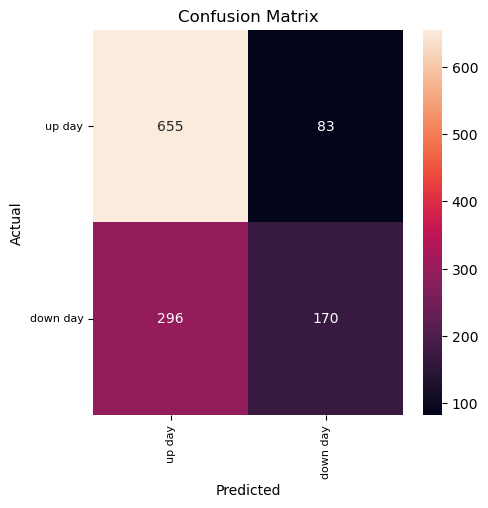

In [112]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['up day','down day'])
ax.yaxis.set_ticklabels(['up day','down day'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()

### Random Data Testing

In [47]:
# data extraction 
start_date = '2017-01-1'
end_date = '2022-06-01'
symbol = "SPY"
data = DataReader(name=symbol, data_source="yahoo", start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Adj Close", "Volume"]]

In [48]:
# add return and range 
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1 # because latter - previous value in row level 
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2017-01-04,225.619995,226.750000,225.610001,205.000458,78744400.0,0.005949,0.005053
2017-01-05,226.270004,226.580002,225.479996,204.837585,78379000.0,-0.000794,0.004879
2017-01-06,226.529999,227.750000,225.899994,205.570404,71559900.0,0.003578,0.008189
2017-01-09,226.910004,227.070007,226.419998,204.891876,46939700.0,-0.003301,0.002871
2017-01-10,226.479996,227.449997,226.009995,204.891876,63771900.0,0.000000,0.006371


In [49]:
# structure data 
X_train = df[["Returns", "Range"]]
X_train.head()

,Returns,Range
Date,,
2017-01-04,0.005949,0.005053
2017-01-05,-0.000794,0.004879
2017-01-06,0.003578,0.008189
2017-01-09,-0.003301,0.002871
2017-01-10,0.000000,0.006371


### HMM Learning

In [50]:
from pyhhmm.gaussian import GaussianHMM
# Train Model 
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])

(<pyhhmm.gaussian.GaussianHMM at 0x2a39dbd90>, 9650.373823399583)

In [51]:
# check results 
hidden_states = model.predict([X_train.values])[0]
hidden_states[:40]
len(hidden_states)

1362

In [52]:
# regime state means for each feature 
model.means

array([[ 0.00260717,  0.00720447],
       [-0.01150726,  0.02775624],
       [ 0.01490649,  0.02661821],
       [-0.00303335,  0.01266944]])

In [53]:
# 
model.covars

array([[[ 3.80965369e-05,  1.79201186e-05],
        [ 1.79201186e-05,  2.29707595e-05]],

       [[ 5.18131394e-04, -9.81855457e-05],
        [-9.81855457e-05,  2.47720250e-04]],

       [[ 6.25853706e-04,  3.99640332e-04],
        [ 3.99640332e-04,  3.99748774e-04]],

       [[ 1.34683431e-04,  3.19242118e-05],
        [ 3.19242118e-05,  7.59399869e-05]]])

In [54]:
# helper function
# dir(model)

### Data Visualization

In [55]:
# structure the prices for plotting 
i = 0
labels_0 = []
labels_1 = [] 
labels_2 = [] 
labels_3 = []
prices = df["Adj Close"].values.astype(float)
print("Correct number of rows:", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
    i += 1

Correct number of rows: True


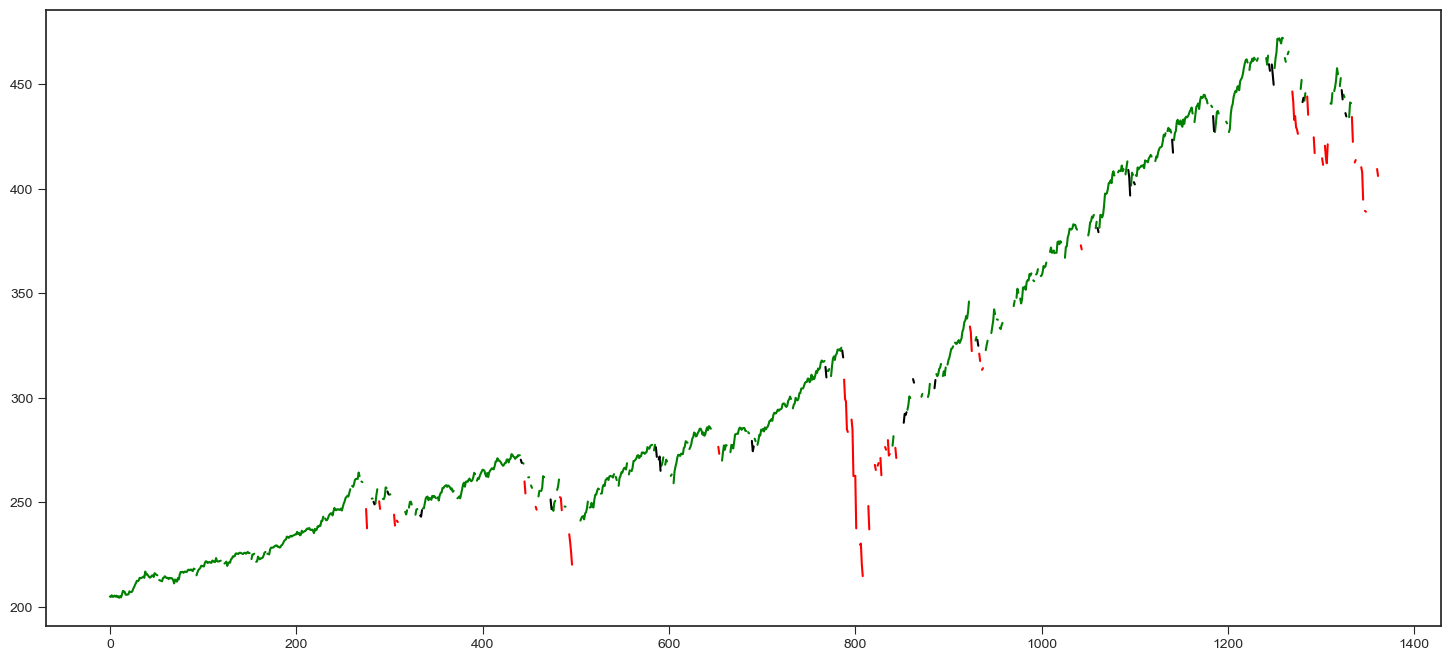

In [56]:
# plot chart 
fig = plt.figure(figsize=(18, 8))
plt.plot(labels_0, color="green")
plt.plot(labels_1, color="red")
plt.plot(labels_2, color="orange")
plt.plot(labels_3, color="black")
plt.show()

In [57]:
# moving average 
# https://www.youtube.com/watch?v=r3Ulu0jZCJI
# define a period as a day, for example a 20 days moving average, take value of 20 days and adding together / count
# this result is used as a value for the first day of that 20 days 
# when moving forward a day, drop the current first day and include a new day followed the current last day
# and do the calculation for that

In [58]:
# binning data: make continuous data into categorical data
# https://www.youtube.com/watch?v=iv_ec0EfXcE

# equal frequency binding in python